# Displaying image data in TensorBoard

## 0. Overview

## 1. Setup

In [1]:
from datetime import datetime
import io
import itertools
from packaging import version

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn.metrics

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.4.1


## 2. Download the Fashion-MNIST dataset

In [2]:
# First, download the data:


# Download the data. The data is already divided into train and test.
# The labels are integers representing classes.
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = \
    fashion_mnist.load_data()

# Names of the integer classes, i.e., 0 -> T-short/top, 1 -> Trouser, etc.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 3. Visualizing a single image

In [3]:
# Before you do that, examine the shape of your training data:

print("Shape: ", train_images[0].shape)
print("Label: ", train_labels[0], "->", class_names[train_labels[0]])

Shape:  (28, 28)
Label:  9 -> Ankle boot


In [4]:
# Reshape the image for the Summary API.
img = np.reshape(train_images[0], (-1, 28, 28, 1))

In [6]:
# You're now ready to log this image and view it in TensorBoard.

# Clear out any prior log data.
# !rm -rf logs

# Sets up a timestamped log directory.
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Training data", img, step=0)

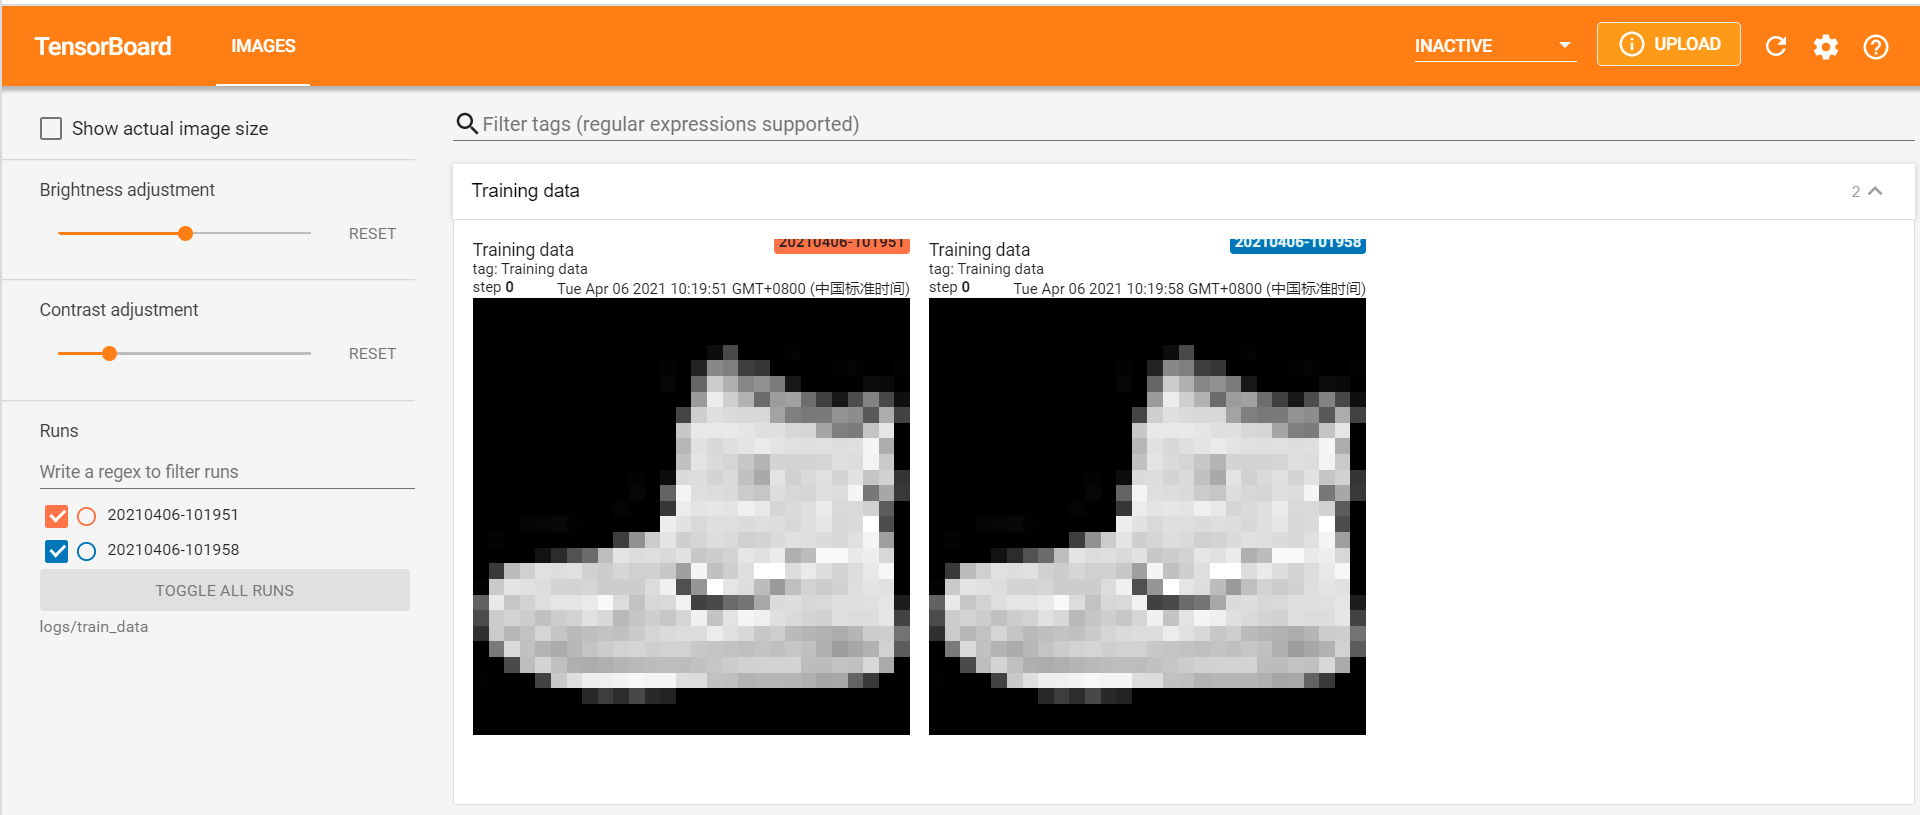

In [8]:
from IPython.display import Image, display
display(Image(filename="./image/imageData.png", embed=True))

## 4. Visualizing multiple images

In [9]:
with file_writer.as_default():
  # Don't forget to reshape.
  images = np.reshape(train_images[0:25], (-1, 28, 28, 1))
  tf.summary.image("25 training data examples", images, max_outputs=25, step=0)

# %tensorboard --logdir logs/train_data

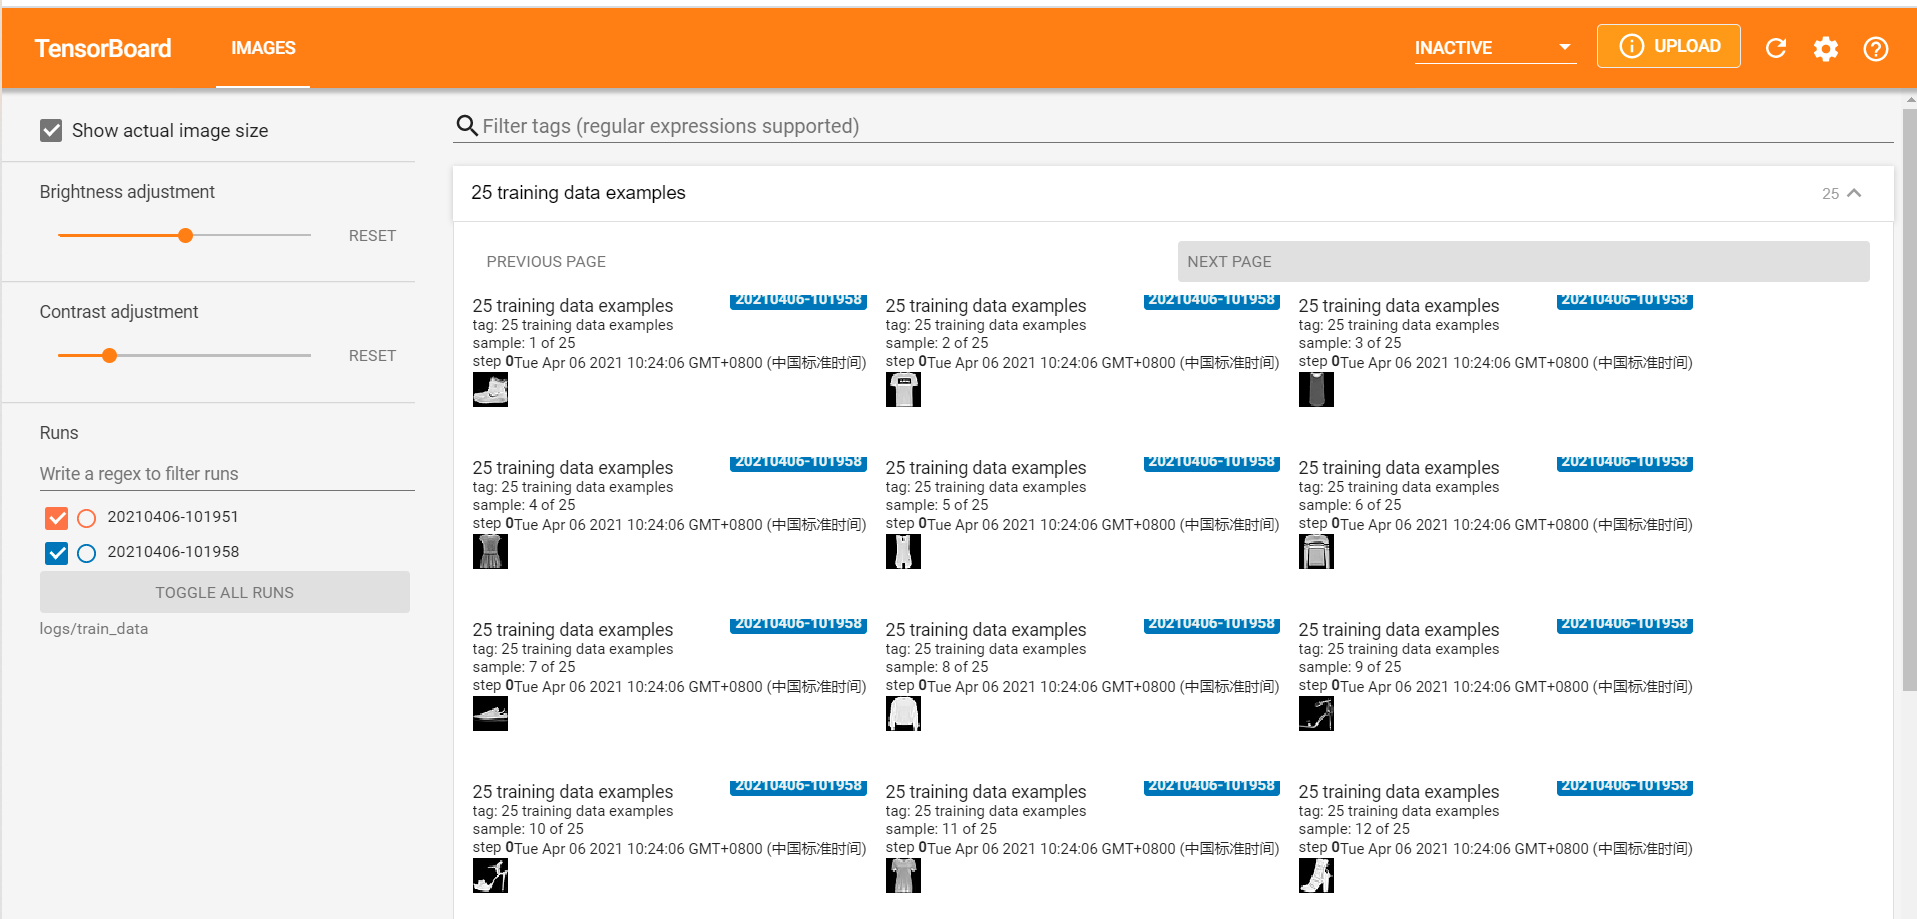

In [10]:
from IPython.display import Image, display
display(Image(filename="./image/imageData2.png", embed=True))

## 5. Logging arbitrary image data

In [12]:
# Clear out prior logging data.
# !rm -rf logs/plots

logdir = "logs/plots/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=class_names[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)

  return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
  tf.summary.image("Training data", plot_to_image(figure), step=0)

# %tensorboard --logdir logs/plots

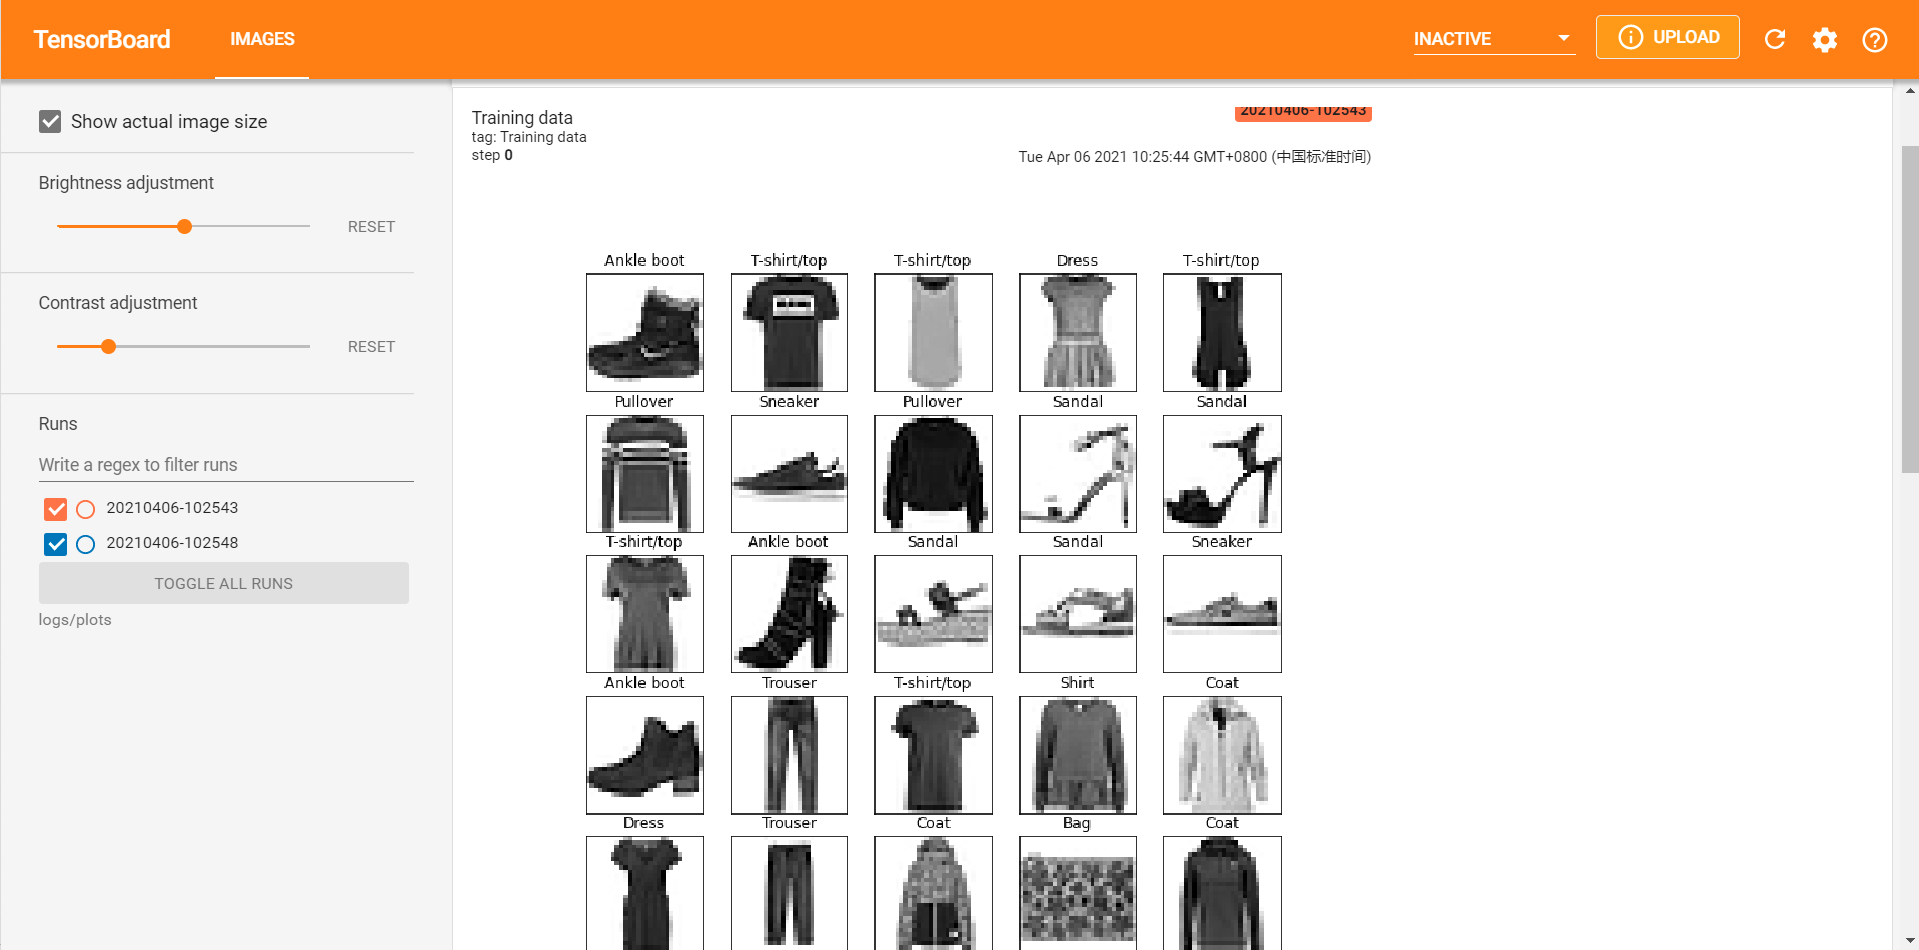

In [13]:
from IPython.display import Image, display
display(Image(filename="./image/imageData3.png", embed=True))

## 6. Building an image classifier

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

In [17]:
# Clear out prior logging data.
# !rm -rf logs/image

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [18]:
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(test_images)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [19]:
# Start TensorBoard.
# %tensorboard --logdir logs/image

# Train the classifier.
model.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=0, # Suppress chatty output
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_images, test_labels),
)

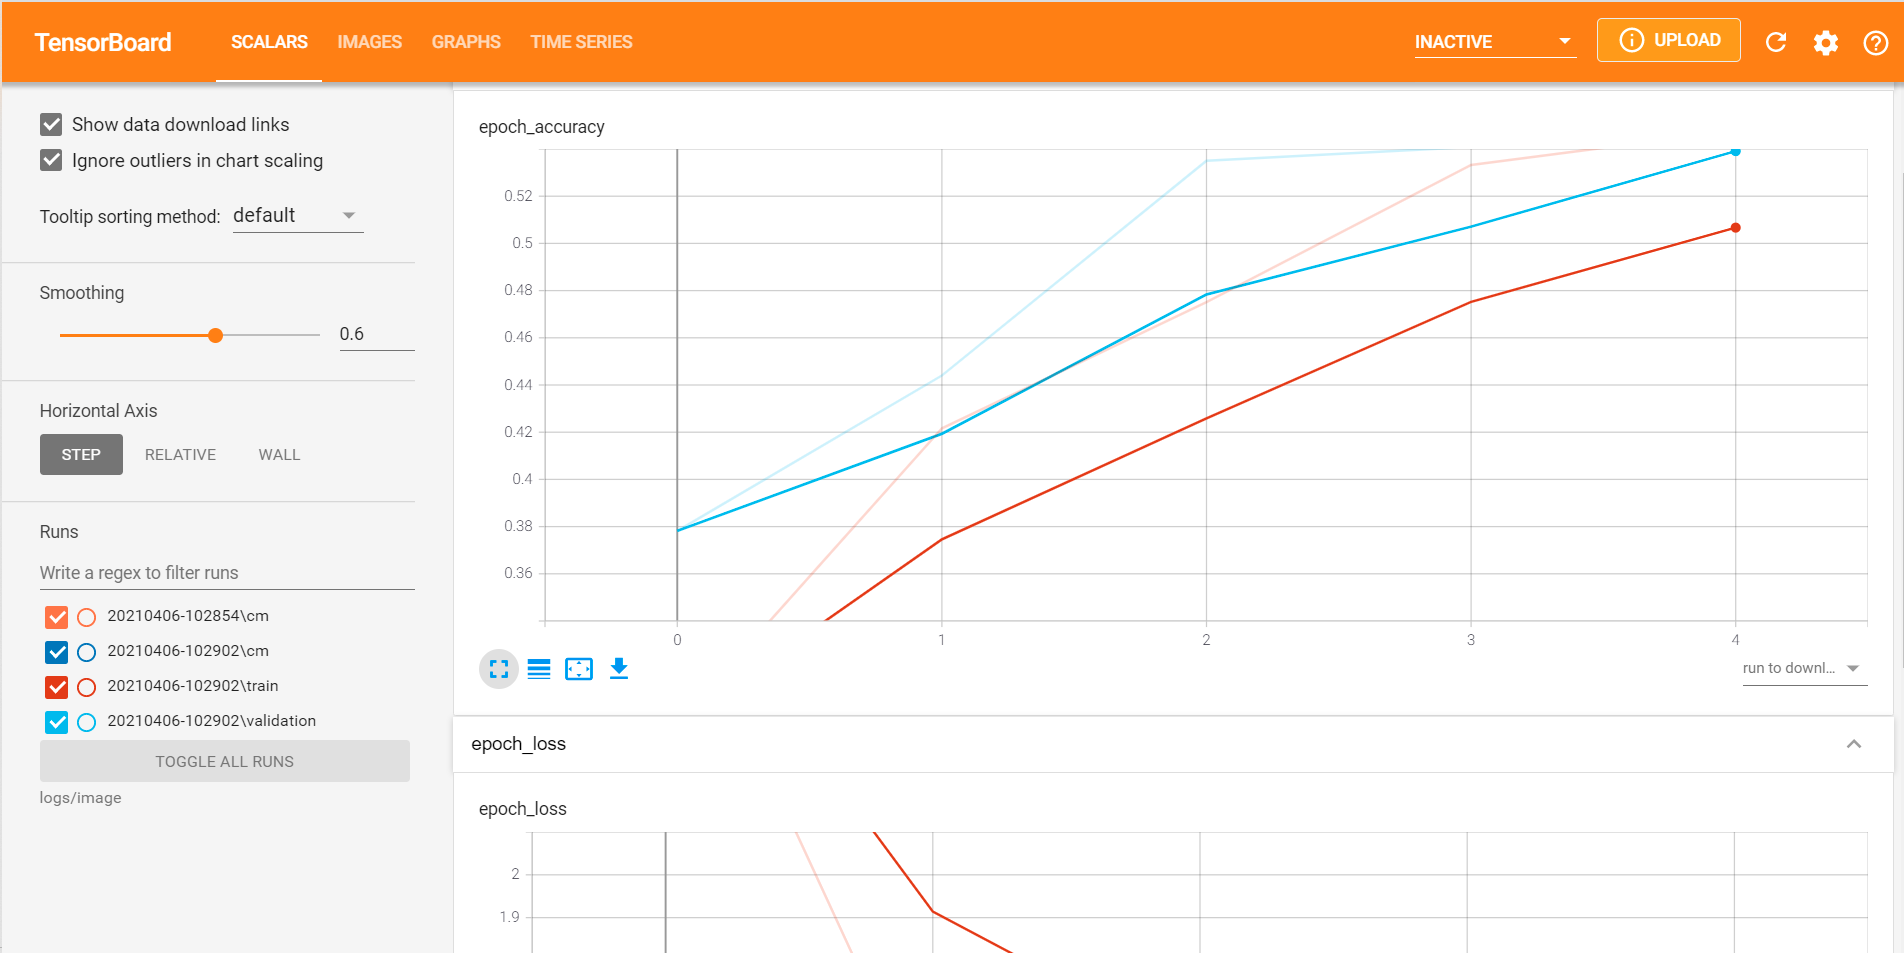

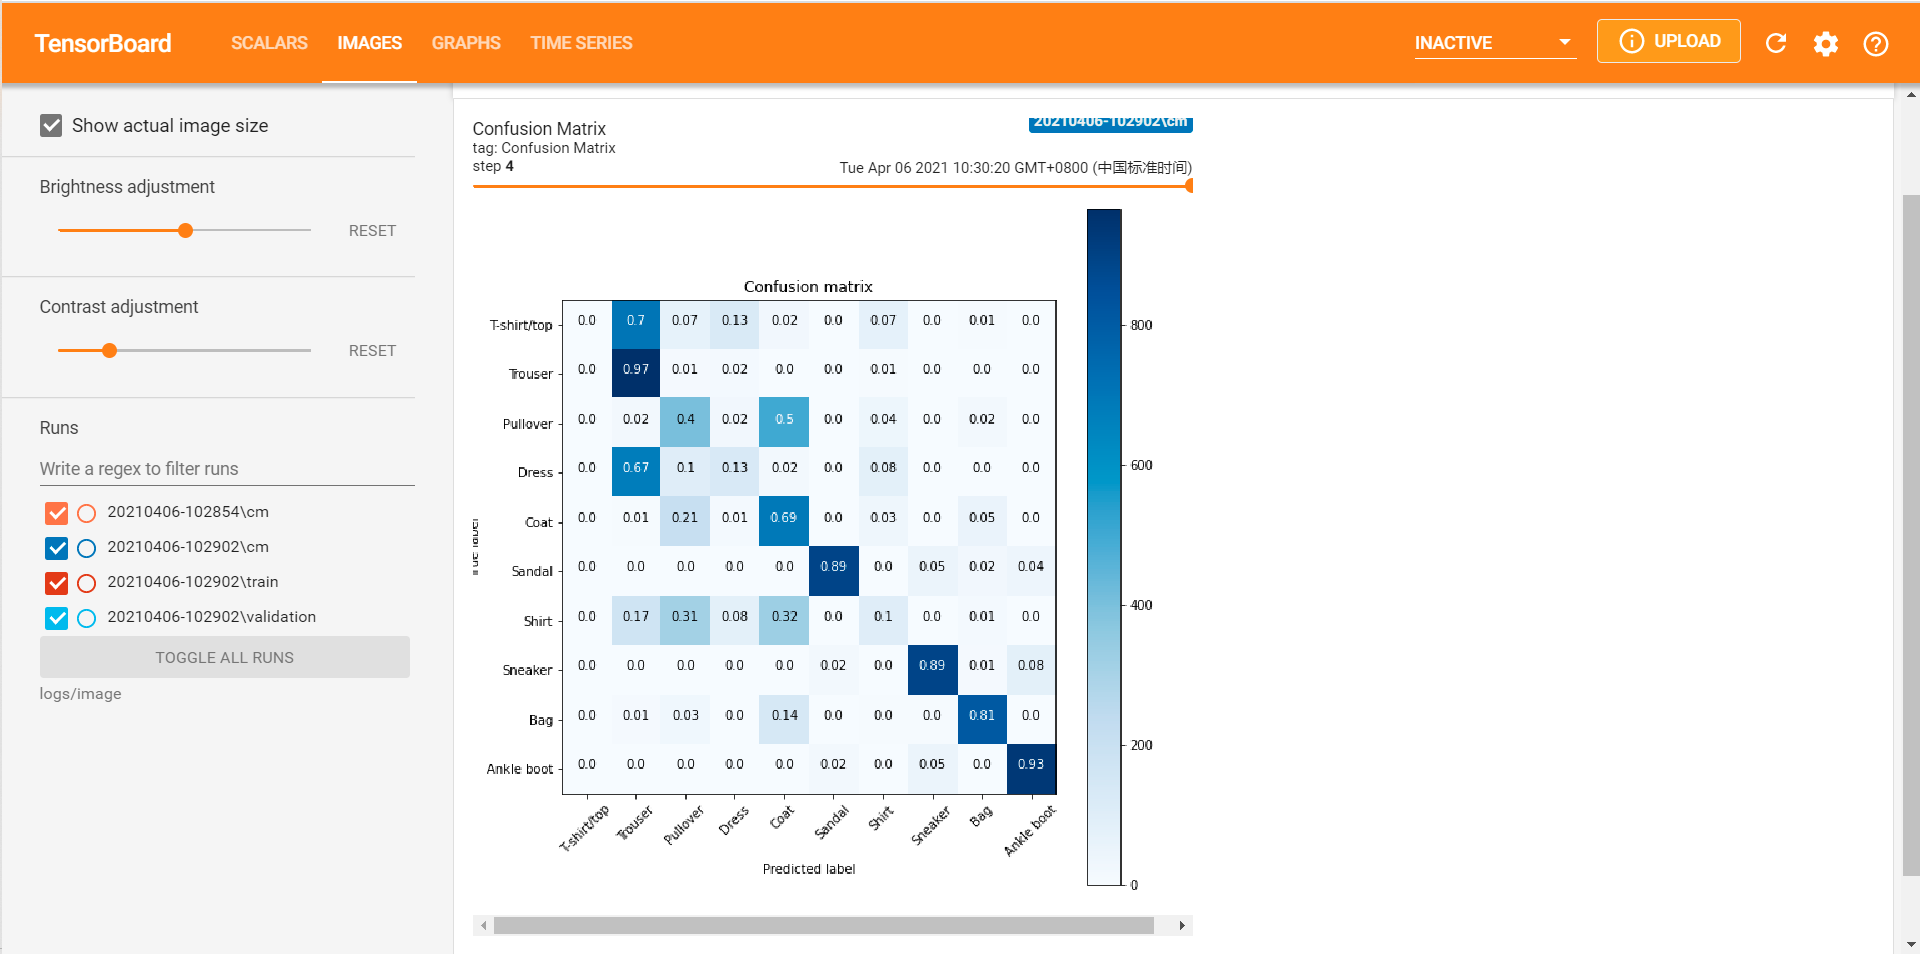

In [20]:
from IPython.display import Image, display
display(Image(filename="./image/imageData4.png", embed=True))
display(Image(filename="./image/imageData5.png", embed=True))

# reference

### https://tensorflow.google.cn/tensorboard/image_summaries